In [1]:
import numpy as np  
import pandas as pd  
from re import search


from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization, ELU  

# Model utilities for VGG16, callbacks, and preprocessing
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import matplotlib.pyplot as plt
from PIL import Image
import PIL
import pathlib


from sklearn.metrics import confusion_matrix

import glob
import shutil

from matplotlib import gridspec

import cv2
from random import shuffle

print("Setup completed")


Setup completed


In [2]:
IMAGE_SIZE = 128
CLASSES = ['0', '1', '2', '3']
LR = 1e-3
DIR = r'E:/DS_Advanced_NLP_Deep_Learning/DL_Projects/Foliar_Diseases_in_Apple_Trees/data/images'
train_dataset = pd.read_csv(r'E:/DS_Advanced_NLP_Deep_Learning/DL_Projects/Foliar_Diseases_in_Apple_Trees/data/train.csv')
print(train_dataset)
test_dataset = pd.read_csv(r'E:/DS_Advanced_NLP_Deep_Learning/DL_Projects/Foliar_Diseases_in_Apple_Trees/data/test.csv')
print(test_dataset)

        image_id  healthy  multiple_diseases  rust  scab
0        Train_0        0                  0     0     1
1        Train_1        0                  1     0     0
2        Train_2        1                  0     0     0
3        Train_3        0                  0     1     0
4        Train_4        1                  0     0     0
...          ...      ...                ...   ...   ...
1816  Train_1816        0                  0     0     1
1817  Train_1817        1                  0     0     0
1818  Train_1818        1                  0     0     0
1819  Train_1819        0                  0     1     0
1820  Train_1820        0                  0     0     1

[1821 rows x 5 columns]
       image_id
0        Test_0
1        Test_1
2        Test_2
3        Test_3
4        Test_4
...         ...
1816  Test_1816
1817  Test_1817
1818  Test_1818
1819  Test_1819
1820  Test_1820

[1821 rows x 1 columns]


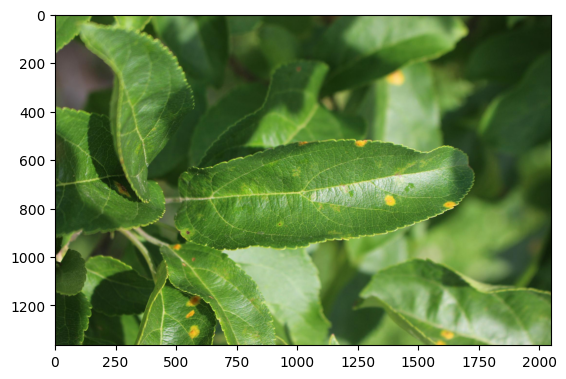

In [3]:
# Convert the first image into an array
image = Image.open('E:/DS_Advanced_NLP_Deep_Learning/DL_Projects/Foliar_Diseases_in_Apple_Trees/data/images/Test_0.jpg');
#print(np.asarray(image))
img_open = plt.imshow(image)

In [4]:
print(train_dataset.head())

  image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0


In [5]:
train_dataset['image_id'] = train_dataset['image_id'] + '.jpg'
print(train_dataset.shape)
print(train_dataset)
#define the class names
class_names = train_dataset.loc[:, 'healthy':].columns
print(class_names)

(1821, 5)
            image_id  healthy  multiple_diseases  rust  scab
0        Train_0.jpg        0                  0     0     1
1        Train_1.jpg        0                  1     0     0
2        Train_2.jpg        1                  0     0     0
3        Train_3.jpg        0                  0     1     0
4        Train_4.jpg        1                  0     0     0
...              ...      ...                ...   ...   ...
1816  Train_1816.jpg        0                  0     0     1
1817  Train_1817.jpg        1                  0     0     0
1818  Train_1818.jpg        1                  0     0     0
1819  Train_1819.jpg        0                  0     1     0
1820  Train_1820.jpg        0                  0     0     1

[1821 rows x 5 columns]
Index(['healthy', 'multiple_diseases', 'rust', 'scab'], dtype='object')


In [6]:
counter = 0
train_dataset['label'] = 0
for name in class_names:
    train_dataset['label'] = train_dataset['label'] + train_dataset[name] * counter
    counter = counter + 1
    
print(train_dataset)

            image_id  healthy  multiple_diseases  rust  scab  label
0        Train_0.jpg        0                  0     0     1      3
1        Train_1.jpg        0                  1     0     0      1
2        Train_2.jpg        1                  0     0     0      0
3        Train_3.jpg        0                  0     1     0      2
4        Train_4.jpg        1                  0     0     0      0
...              ...      ...                ...   ...   ...    ...
1816  Train_1816.jpg        0                  0     0     1      3
1817  Train_1817.jpg        1                  0     0     0      0
1818  Train_1818.jpg        1                  0     0     0      0
1819  Train_1819.jpg        0                  0     1     0      2
1820  Train_1820.jpg        0                  0     0     1      3

[1821 rows x 6 columns]


#### Prepare for training

In [7]:
def get_label_img(img):
    if search("Train", img):
        label = train_dataset.loc[train_dataset["image_id"] == img]['label']
        return label

In [8]:
train_dataset

,image_id,healthy,multiple_diseases,rust,scab,label
0,Train_0.jpg,0,0,0,1,3
1,Train_1.jpg,0,1,0,0,1
2,Train_2.jpg,1,0,0,0,0
3,Train_3.jpg,0,0,1,0,2
4,Train_4.jpg,1,0,0,0,0
...,...,...,...,...,...,...
1816,Train_1816.jpg,0,0,0,1,3
1817,Train_1817.jpg,1,0,0,0,0
1818,Train_1818.jpg,1,0,0,0,0
1819,Train_1819.jpg,0,0,1,0,2


In [9]:
import natsort
def create_train_data():
    images = natsort.natsorted(os.listdir(DIR))
    for img in tqdm(images):
        label = get_label_img(img)
        path = os.path.join(DIR, img)
        #image_name = img
        #img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMAGE_SIZE, IMAGE_SIZE))
        
        if search("Train", img):
            if int(img.split("_")[1].split(".")[0])  and label.item() == 0 :
                shutil.copy(path, r'E:/DS_Advanced_NLP_Deep_Learning/DL_Projects/Foliar_Diseases_in_Apple_Trees/data/train/healthy')
            elif int(img.split("_")[1].split(".")[0])  and label.item() == 1:
                shutil.copy(path, r'E:/DS_Advanced_NLP_Deep_Learning/DL_Projects/Foliar_Diseases_in_Apple_Trees/data/multiple_diseases')
            elif int(img.split("_")[1].split(".")[0])  and label.item() == 2:
                shutil.copy(path, r'E:/DS_Advanced_NLP_Deep_Learning/DL_Projects/Foliar_Diseases_in_Apple_Trees/data/train/rust')
            elif int(img.split("_")[1].split(".")[0])  and label.item() == 3:
                shutil.copy(path, r'E:/DS_Advanced_NLP_Deep_Learning/DL_Projects/Foliar_Diseases_in_Apple_Trees/data/train/scab')

                
        elif search("Test", img):
            shutil.copy(path, r'E:/DS_Advanced_NLP_Deep_Learning/DL_Projects/Foliar_Diseases_in_Apple_Trees/data/test/') 

In [10]:
import os 

shutil.os.mkdir(r'E:/DS_Advanced_NLP_Deep_Learning/DL_Projects/Foliar_Diseases_in_Apple_Trees/data/train/')
shutil.os.mkdir(r'E:/DS_Advanced_NLP_Deep_Learning/DL_Projects/Foliar_Diseases_in_Apple_Trees/data/test/')
shutil.os.mkdir(r'E:/DS_Advanced_NLP_Deep_Learning/DL_Projects/Foliar_Diseases_in_Apple_Trees/data/train/healthy/')
shutil.os.mkdir(r'E:/DS_Advanced_NLP_Deep_Learning/DL_Projects/Foliar_Diseases_in_Apple_Trees/data/train/multiple_diseases/')
shutil.os.mkdir(r'E:/DS_Advanced_NLP_Deep_Learning/DL_Projects/Foliar_Diseases_in_Apple_Trees/data/train/rust/')
shutil.os.mkdir(r'E:/DS_Advanced_NLP_Deep_Learning/DL_Projects/Foliar_Diseases_in_Apple_Trees/data/train/scab/')
train_data = create_train_data()

100%|██████████| 3642/3642 [00:33<00:00, 110.16it/s]


#### Models

In [11]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [12]:
# Convolutional Neural Network

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
tf.__version__

'2.17.0'

In [14]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6812153986004483764
xla_global_id: -1
]


In [15]:
tf.config.list_physical_devices('GPU')

[]

In [16]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [17]:
tf.config.list_physical_devices('GPU')

[]

#### Data Preprocessing

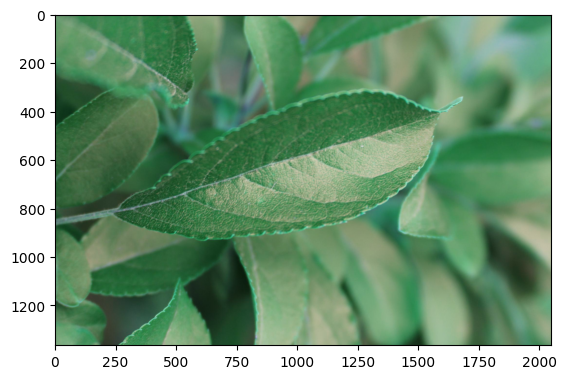

In [18]:
DATADIR = r"E:/DS_Advanced_NLP_Deep_Learning/DL_Projects/Foliar_Diseases_in_Apple_Trees/data/train/"

CATEGORIES = ["healthy", "multiple_diseases","rust","scab"]

for category in CATEGORIES:  # do dogs and cats
    path = os.path.join(DATADIR,category)  # create path to dogs and cats
    for img in os.listdir(path):  # iterate over each image per dogs and cats
        img_array = cv2.imread(os.path.join(path,img) ,cv2.COLOR_BGR2RGB)  # convert to array
        plt.imshow(img_array)  # graph it
        plt.show()  # display!

        break  # we just want one for now so break
    break  #...and one more!

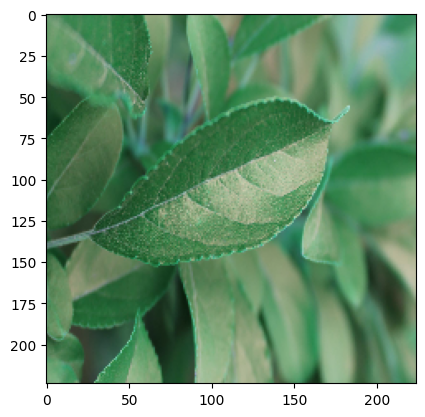

In [19]:
IMG_SIZE = 224

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array)
plt.show()

In [20]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    r'E:/DS_Advanced_NLP_Deep_Learning/DL_Projects/Foliar_Diseases_in_Apple_Trees/data/train/',
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
   r'E:/DS_Advanced_NLP_Deep_Learning/DL_Projects/Foliar_Diseases_in_Apple_Trees/data/train', # same directory as training data
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 1384 images belonging to 4 classes.
Found 345 images belonging to 4 classes.


In [21]:
from tensorflow.keras.layers import Conv2D
Conv2D(filters=32,padding="same",kernel_size=3)

<Conv2D name=conv2d, built=False>

In [22]:
# define cnn model
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(4, activation='softmax'))
# compile model
opt = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    name='Adam'
)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\Sahishnuta\anaconda3\envs\apple\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 28, 28, 128)    │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │       100,356 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,324 (720.02 KB)

 Trainable params: 184,324 (720.02 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
checkpoint = ModelCheckpoint("E:/DS_Advanced_NLP_Deep_Learning/DL_Projects/Foliar_Diseases_in_Apple_Trees/models/apple-224.keras",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

In [24]:
# Part 3 - Training the CNN

# Compiling the CNN
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Training the CNN on the Training set and evaluating it on the Test set
history=model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // 16,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // 16,
    callbacks=callbacks,
    epochs = 30)

c:\Users\Sahishnuta\anaconda3\envs\apple\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3469 - loss: 1.9694
Epoch 1: val_loss improved from inf to 1.05500, saving model to E:/DS_Advanced_NLP_Deep_Learning/DL_Projects/Foliar_Diseases_in_Apple_Trees/models/apple-224.keras
86/86 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.3473 - loss: 1.9622 - val_accuracy: 0.4375 - val_loss: 1.0550
Epoch 2/30
 1/86 ━━━━━━━━━━━━━━━━━━━━ 1:35 1s/step - accuracy: 0.4375 - loss: 1.0634

c:\Users\Sahishnuta\anaconda3\envs\apple\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 1.05500
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4375 - loss: 1.0634 - val_accuracy: 0.3333 - val_loss: 1.1108
Epoch 3/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4681 - loss: 1.0643
Epoch 3: val_loss improved from 1.05500 to 1.04302, saving model to E:/DS_Advanced_NLP_Deep_Learning/DL_Projects/Foliar_Diseases_in_Apple_Trees/models/apple-224.keras
86/86 ━━━━━━━━━━━━━━━━━━━━ 232s 3s/step - accuracy: 0.4677 - loss: 1.0645 - val_accuracy: 0.4405 - val_loss: 1.0430
Epoch 4/30
 1/86 ━━━━━━━━━━━━━━━━━━━━ 1:46 1s/step - accuracy: 0.5000 - loss: 0.9737
Epoch 4: val_loss did not improve from 1.04302
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5000 - loss: 0.9737 - val_accuracy: 0.4444 - val_loss: 1.1954
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4693 - loss: 1.0313
Epoch 5: val_loss did not improve from 1.04302
86/86 ━━━━━━━━━━━━━━━━━━━━ 280s 3s/step - accuracy: 0.4695 - loss: 1.0313 - val_accuracy: 0.36

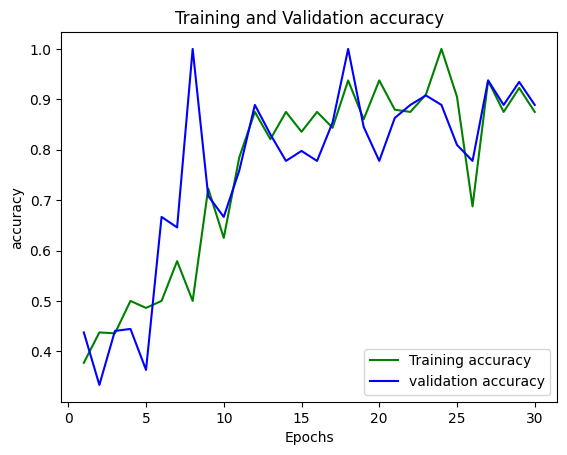

In [25]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,31)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

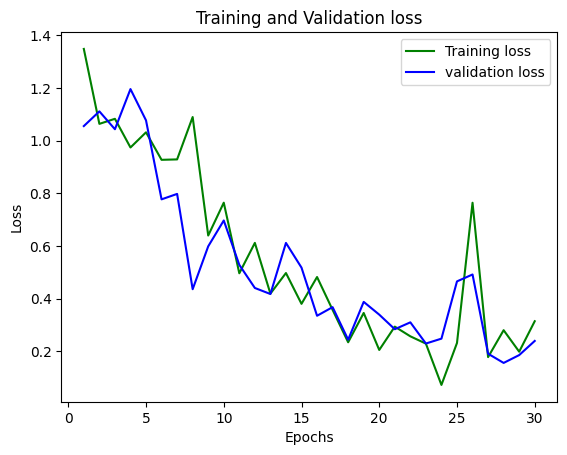

In [26]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,31)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
# save it as a h5 file

model.save(r'E:/DS_Advanced_NLP_Deep_Learning/DL_Projects/Foliar_Diseases_in_Apple_Trees/models/model_apple-2.keras')

In [29]:
from tensorflow.keras.models import load_model
 
# load model
#model = load_model(r'D:\Python37\Projects\Foliar diseases in apple trees\apple-3.h5')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 28, 28, 128)    │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │       100,356 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 552,974 (2.11 MB)

 Trainable params: 184,324 (720.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 368,650 (1.41 MB)

#### Making a single prediction

In [30]:
test_image_single=(r'E:/DS_Advanced_NLP_Deep_Learning/DL_Projects/Foliar_Diseases_in_Apple_Trees/data/images/Train_2.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[0]


C:\Users\Sahishnuta\AppData\Local\Temp\ipykernel_2772\3863068777.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(categories[int(np.argmax(result,axis=1))])


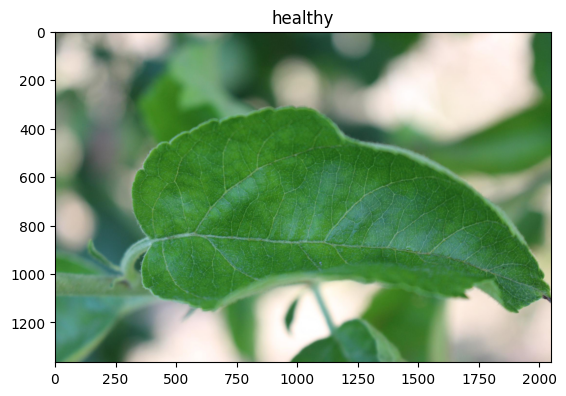

In [31]:
import numpy as np
from tensorflow.keras.preprocessing import image
test_image = image.load_img(test_image_single, target_size = (224,224))
test_image = image.img_to_array(test_image)
test_image=test_image/255
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
print(np.argmax(result,axis=1))
categories = ['healthy', 'multiple diseases', 'rust', 'scab']
categories[np.argmax(result)]
image_h = Image.open(test_image_single)
img_h = plt.imshow(image_h)
plt.title(categories[int(np.argmax(result,axis=1))])
plt.show()